In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


In [14]:
boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame

X = df[["RM", "CRIM"]].values
y = df["MEDV"].values.reshape(-1, 1)

X = (X - X.mean(axis=0)) / X.std(axis=0)

y = (y - y.mean()) / y.std()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
def relu(z):
    return np.maximum(0, z)

def relu_grad(z):
    return (z > 0).astype(float)


In [16]:
class NeuralNetwork:
    def __init__(self, layer_sizes, lr=0.01, optimizer="gd", l2_lambda=0.0):
        self.lr = lr
        self.optimizer = optimizer
        self.l2_lambda = l2_lambda
        self.layers = len(layer_sizes) - 1

        self.W, self.b = [], []
        for i in range(self.layers):
            self.W.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.1)
            self.b.append(np.zeros((1, layer_sizes[i+1])))

        # Optimizer states
        self.vW = [np.zeros_like(w) for w in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]
        self.mW = [np.zeros_like(w) for w in self.W]
        self.vvW = [np.zeros_like(w) for w in self.W]
        self.mb = [np.zeros_like(b) for b in self.b]
        self.vvb = [np.zeros_like(b) for b in self.b]

        self.t = 1


    def forward(self, X):
        self.Z = []
        self.A = [X]

        for i in range(self.layers - 1):
            z = self.A[-1] @ self.W[i] + self.b[i]
            self.Z.append(z)
            self.A.append(relu(z))

        z = self.A[-1] @ self.W[-1] + self.b[-1]
        self.Z.append(z)
        self.A.append(z)
        return z


    def loss(self, y_pred, y_true):
        mse = np.mean((y_pred - y_true) ** 2)
        l2 = self.l2_lambda * sum(np.sum(w**2) for w in self.W)
        return mse + l2


    def backward(self, y_true):
        m = y_true.shape[0]
        dZ = (self.A[-1] - y_true) / m

        grads_W, grads_b = [], []

        for i in reversed(range(self.layers)):
            dW = self.A[i].T @ dZ + 2 * self.l2_lambda * self.W[i]
            db = np.sum(dZ, axis=0, keepdims=True)

            grads_W.insert(0, dW)
            grads_b.insert(0, db)

            if i > 0:
                dA = dZ @ self.W[i].T
                dZ = dA * relu_grad(self.Z[i-1])

        if self.optimizer == "gd":
            for i in range(self.layers):
                self.W[i] -= self.lr * grads_W[i]
                self.b[i] -= self.lr * grads_b[i]

        elif self.optimizer == "momentum":
            beta = 0.9
            for i in range(self.layers):
                self.vW[i] = beta*self.vW[i] + self.lr*grads_W[i]
                self.vb[i] = beta*self.vb[i] + self.lr*grads_b[i]
                self.W[i] -= self.vW[i]
                self.b[i] -= self.vb[i]

        elif self.optimizer == "adam":
            beta1, beta2, eps = 0.9, 0.999, 1e-8
            for i in range(self.layers):
                self.mW[i] = beta1*self.mW[i] + (1-beta1)*grads_W[i]
                self.vvW[i] = beta2*self.vvW[i] + (1-beta2)*(grads_W[i]**2)

                m_hat = self.mW[i] / (1-beta1**self.t)
                v_hat = self.vvW[i] / (1-beta2**self.t)

                self.W[i] -= self.lr * m_hat / (np.sqrt(v_hat) + eps)
                self.b[i] -= self.lr * grads_b[i]

        self.t += 1


In [17]:
def train(model, X, y, epochs=1000):
    losses = []
    for _ in range(epochs):
        y_pred = model.forward(X)
        losses.append(model.loss(y_pred, y))
        model.backward(y)
    return losses


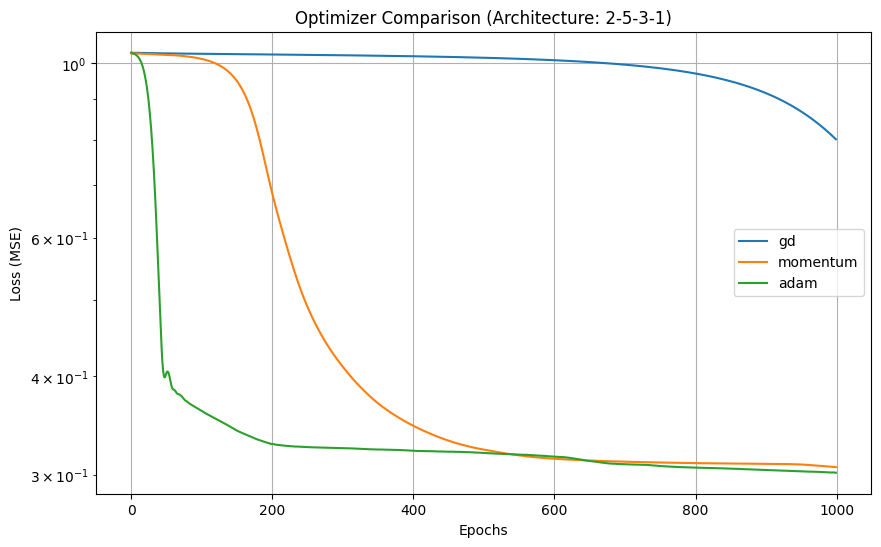

In [18]:
optimizers = ["gd", "momentum", "adam"]
plt.figure(figsize=(10, 6))

for opt in optimizers:
    model = NeuralNetwork([2, 5, 3, 1], lr=0.01, optimizer=opt)
    losses = train(model, X_train, y_train)
    plt.plot(losses, label=opt)

plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Optimizer Comparison (Architecture: 2-5-3-1)")
plt.legend()
plt.grid(True)
plt.show()


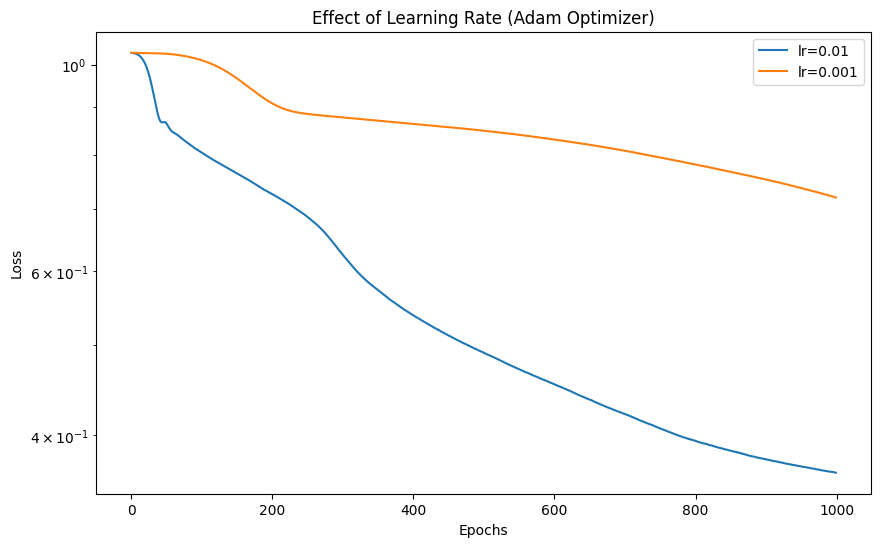

In [19]:
learning_rates = [0.01, 0.001]
plt.figure(figsize=(10, 6))

for lr in learning_rates:
    model = NeuralNetwork([2, 5, 3, 1], lr=lr, optimizer="adam")
    losses = train(model, X_train, y_train)
    plt.plot(losses, label=f"lr={lr}")

plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Effect of Learning Rate (Adam Optimizer)")
plt.legend()
plt.show()


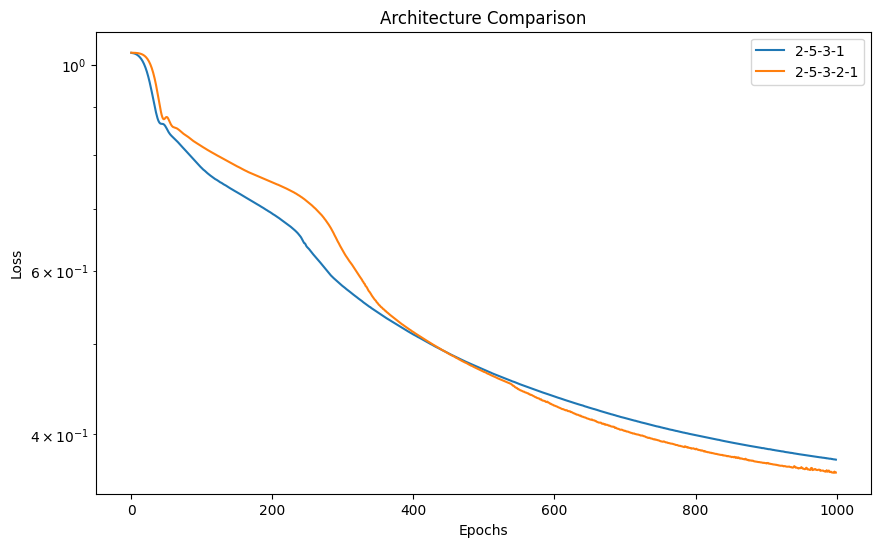

In [20]:
plt.figure(figsize=(10, 6))

model_A = NeuralNetwork([2, 5, 3, 1], lr=0.01, optimizer="adam")
loss_A = train(model_A, X_train, y_train)

model_B = NeuralNetwork([2, 5, 3, 2, 1], lr=0.01, optimizer="adam")
loss_B = train(model_B, X_train, y_train)

plt.plot(loss_A, label="2-5-3-1")
plt.plot(loss_B, label="2-5-3-2-1")

plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Architecture Comparison")
plt.legend()
plt.show()


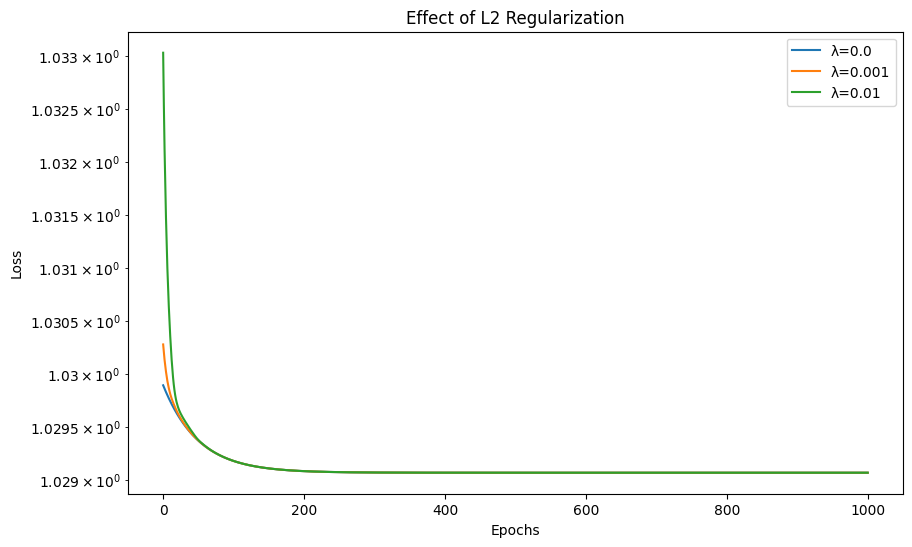

In [21]:
plt.figure(figsize=(10, 6))

for lam in [0.0, 0.001, 0.01]:
    model = NeuralNetwork([2, 5, 3, 2, 1],
                          lr=0.01,
                          optimizer="adam",
                          l2_lambda=lam)
    losses = train(model, X_train, y_train)
    plt.plot(losses, label=f"λ={lam}")

plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Effect of L2 Regularization")
plt.legend()
plt.show()


In [22]:
# Model A evaluation
yA_pred = model_A.forward(X_test)
mse_A = np.mean((yA_pred - y_test)**2)

# Model B evaluation
yB_pred = model_B.forward(X_test)
mse_B = np.mean((yB_pred - y_test)**2)

print("Test MSE (2-5-3-1):", mse_A)
print("Test MSE (2-5-3-2-1):", mse_B)


Test MSE (2-5-3-1): 0.3880777279704806
Test MSE (2-5-3-2-1): 0.4171137210869587


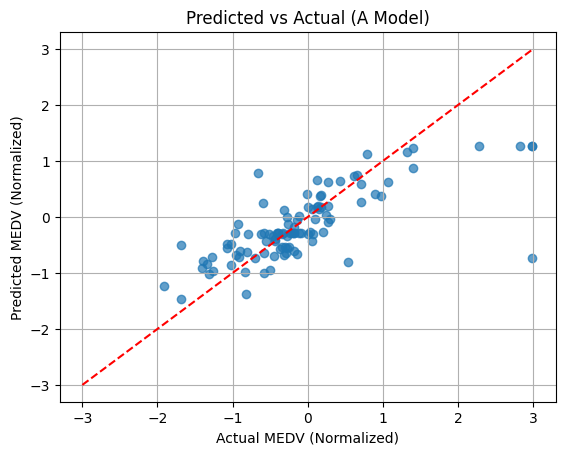

In [23]:
plt.scatter(y_test, yA_pred, alpha=0.7)
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("Actual MEDV (Normalized)")
plt.ylabel("Predicted MEDV (Normalized)")
plt.title("Predicted vs Actual (A Model)")
plt.grid(True)
plt.show()


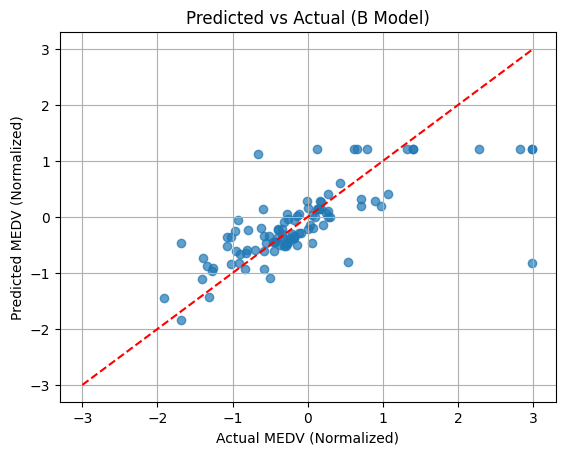

In [24]:
plt.scatter(y_test, yB_pred, alpha=0.7)
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("Actual MEDV (Normalized)")
plt.ylabel("Predicted MEDV (Normalized)")
plt.title("Predicted vs Actual (B Model)")
plt.grid(True)
plt.show()
